# Multi-modal RAG with LangChain

## Extract the data

Extract the elements of the PDF that we will be able to use in the retrieval process. These elements can be: Text, Images, Tables, etc.

### Partition PDF tables, text, and images

In [9]:
from unstructured.partition.pdf import partition_pdf

In [10]:
file_path = '/home/elbahnasy/CodingWorkspace/Hands-On-LLMS/src/multimodality/Transformers-deatils - slides.pdf'
chunks = partition_pdf(
    filename=file_path,
    infer_table_structure=True,
    strategy="hi_res",
    extract_image_block_types=["Image", "Table"],
    extract_image_block_to_payload=True,
    chunking_strategy="by_title",
    languages=["ar", "en"]
    )

In [11]:
set([str(type(chunk)) for chunk in chunks])

{"<class 'unstructured.documents.elements.CompositeElement'>"}

In [12]:
chunks[3].metadata.orig_elements

In [15]:
elements = chunks[3].metadata.orig_elements
chunk_images = [el for el in elements if 'Image' in str(type(el))]
chunk_images[0].to_dict()

{'type': 'Image',
 'element_id': '18094ce8-beaf-48da-a9ea-9864e28f6030',
 'text': 'I  105  103.65  633.01  25.33  ..  152.06  can  255  636.22  2.01  96.25  ..  636.28  go  alone  1001  600  639.22  986.22  9.36  7.22  78.22  9.36  ..  ..  96.35  12.78  Input Tokens  Input IDs  Embeddings ',
 'metadata': {'detection_class_prob': 0.39651593565940857,
  'coordinates': {'points': ((np.float64(302.2373352050781),
     np.float64(473.4982604980469)),
    (np.float64(302.2373352050781), np.float64(1254.4571533203125)),
    (np.float64(2081.6688), np.float64(1254.4571533203125)),
    (np.float64(2081.6688), np.float64(473.4982604980469))),
   'system': 'PixelSpace',
   'layout_width': 2667,
   'layout_height': 1501},
  'last_modified': '2025-05-30T16:56:37',
  'filetype': 'PPM',
  'languages': ['ar', 'en'],
  'page_number': 11,
  'image_base64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIy

### Separate extracted elements into tables, text, and images


In [ ]:
# Helper functions for type checks
def is_table(chunk):
    return "Table" in str(type(chunk))

def is_composite(chunk):
    return "CompositeElement" in str(type(chunk))

# Separate tables and texts using list comprehensions
tables = [chunk for chunk in chunks if is_table(chunk)]
texts = [chunk for chunk in chunks if is_composite(chunk)]

# Get the images from the CompositeElement objects
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if is_composite(chunk):
            chunk_els = getattr(chunk.metadata, "orig_elements", [])
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(getattr(el.metadata, "image_base64", None))
    # Filter out any None values in case image_base64 is missing
    return [img for img in images_b64 if img]

images = get_images_base64(chunks)

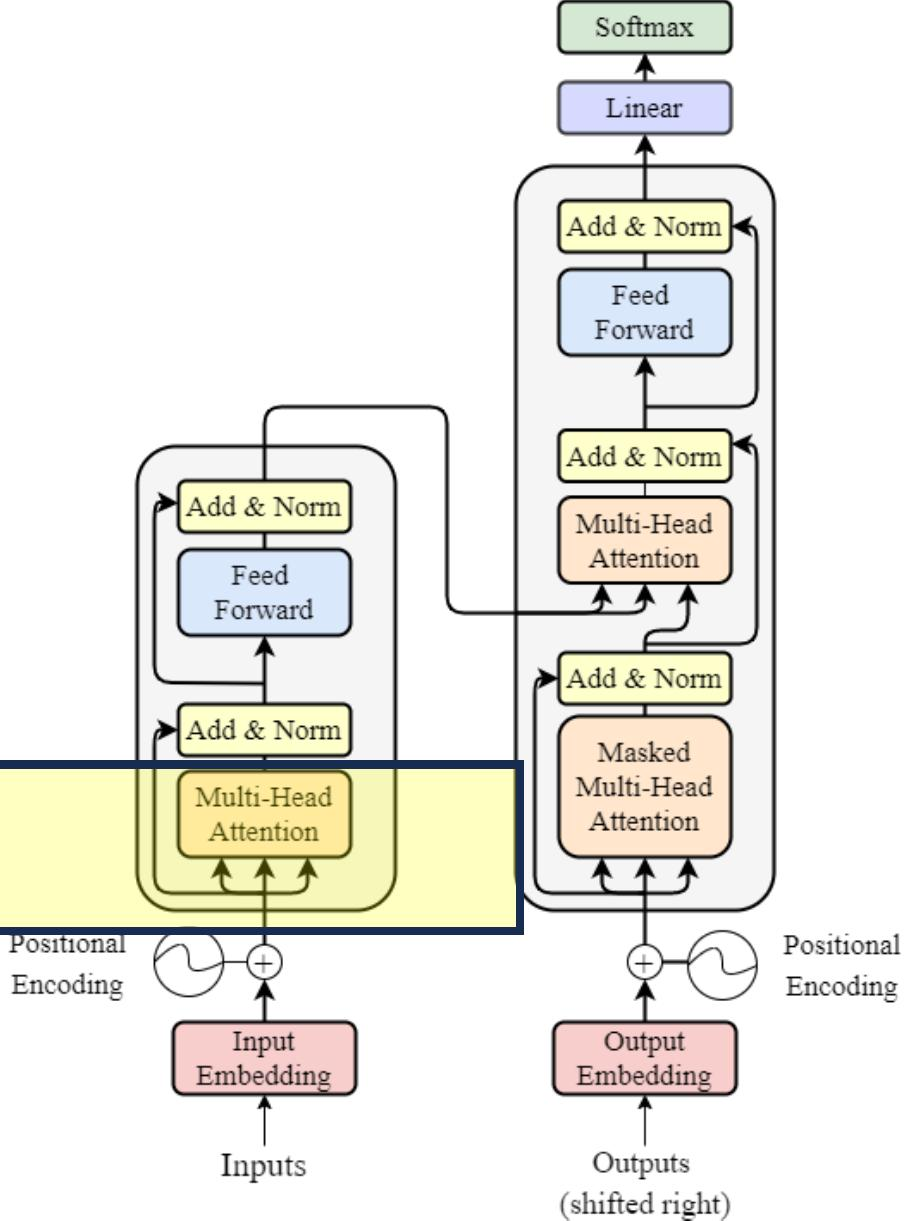

In [24]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

display_base64_image(images[15])